In [1]:
import keras
import matplotlib.pyplot as plt
import time
# load the model 
model_1 = keras.models.load_model("mnist_two_layer_80%.h5")

2021-11-10 10:30:18.011973: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-10 10:30:18.012434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-10 10:30:18.014119: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
# need to use the functions in single_layer_interval_propagation
%run single_layer_interval_propagation.ipynb
%run simple_interval_propagation.ipynb

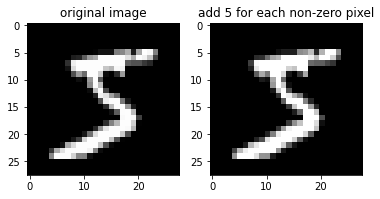

In [3]:
# get the input interval/region
# load the data
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test)=mnist.load_data()
#flatten
x_train = x_train.reshape(x_train.shape[0], -1)

#*******************************************get input_min and input_max*******************************************************
input_min = x_train[0].reshape((1, -1))
input_max = mnist_get_max(input_min, 13)

#plot input_min and input_max
mnist_0_0 = input_min.reshape(28, 28)
mnist_0_5 = input_max.reshape(28, 28)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(mnist_0_0, cmap='gray', vmin=0, vmax=255)
plt.title("original image")
f.add_subplot(1,2, 2)
plt.imshow(mnist_0_5, cmap='gray', vmin=0, vmax=255)
plt.title("add 5 for each non-zero pixel")
plt.show(block=True)

In [ ]:
# the main for loop
# the initial the TODO list--first in first out(large interval has priority)
list_fifo=[]
initial_interval = [input_min, input_max]
list_fifo.append(initial_interval)
counter_example_list = []

# TODO list is first in first out, larger interval has priority.
# get the start time
start_time=time.time()
# set the time out seconds. if this time is reached, it will stop to verify the intervals in the TODO list.
total_seconds = 60*60*8

# certify the nn model is correct within the specified interval
while True:
    
    # update elapsed_time
    elapsed_time = time.time() - start_time
    
    # waiting list is empty represents that all the intervals have been certified.
    if not list_fifo:
        print("the interval certification success! use "+str(elapsed_time)+" seconds! success!")
        break
        
    # when the eplased time has reach the total seconds that we set before 
    # and still can not certify the nn_model with the specified input interval and specification within specified loops
    if elapsed_time > total_seconds:
        print("time out! Searching the counter examples in the TODO list! "+str(len(list_fifo))+" intervals in TODO list!")
        
        # before return time out, check if the regions in the list has counter examples?
        counter_example_list = if_any_counter_example_model_1_small_first(model_1, list_fifo)
        if counter_example_list:
            print("found "+str(len(counter_example_list))+" counter examples:")
            for counter_example in counter_example_list:
                print(counter_example)
            break
        else:
            # if can not find any counter example, print fail notification
            print("Fail to certify the nn model with the given region and specification! use "+str(elapsed_time)+" seconds! And cannot found counter example!")
            break
    
    # pop up the first interval in the waiting list, check if the output interval is satisfy the specification. if not, split into two subintervals
    input_interval = list_fifo.pop(0)
    input_min = input_interval[0]
    input_max = input_interval[1]
    # get the output interval
    output_min, output_max = simple_interval_propagation_model(model_1, input_min, input_max)
    # verify according to the specification
    if not check_specification_model_1(output_min, output_max):# if not satisfy the specification, split into two subintervals and add them to waiting list
        subinterval1, subinterval2 = split_2(input_min, input_max)
        list_fifo.append(subinterval1)
        list_fifo.append(subinterval2)

In [37]:
# the main for loop
# the initial the TODO list--last in first out(small interval has priority)
list_lifo=[]
initial_interval = [input_min, input_max]
list_lifo.append(initial_interval)
counter_example_list = []

# TODO list is first in first out, larger interval has priority.
# get the start time
start_time=time.time()
# set the time out seconds. if this time is reached, it will stop to verify the intervals in the TODO list.
total_seconds = 60*60*2

# certify the nn model is correct within the specified interval
while True:
    
    # update elapsed_time
    elapsed_time = time.time() - start_time
    
    # waiting list is empty represents that all the intervals have been certified.
    if not list_lifo:
        print("the interval certification success! use "+str(elapsed_time)+" seconds! success!")
        break
        
    # when the eplased time has reach the total seconds that we set before 
    # and still can not certify the nn_model with the specified input interval and specification within specified loops
    if elapsed_time > total_seconds:
        print("time out! Searching the counter examples in the TODO list! "+str(len(list_lifo))+" intervals in TODO list!")
        
        # before return time out, check if the regions in the list has counter examples?
        counter_example_list = if_any_counter_example_model_1_small_first(model_1, list_lifo)
        total_used_time = time.time() - start_time
        if counter_example_list:
            print("use "+str(total_used_time)+" seconds! found "+str(len(counter_example_list))+" counter examples:")
            for counter_example in counter_example_list:
                print(counter_example)
            break
        else:
            # if can not find any counter example, print fail notification
            print("Fail to certify the nn model with the given region and specification! use "+str(total_used_time)+" seconds! And cannot found counter example!")
            break
    
    # pop up the first interval in the waiting list, check if the output interval is satisfy the specification. if not, split into two subintervals
    input_interval = list_lifo.pop(len(list_lifo)-1)
    input_min = input_interval[0]
    input_max = input_interval[1]
    # get the output interval
    output_min, output_max = simple_interval_propagation_model(model_1, input_min, input_max)
    # verify according to the specification
    if not check_specification_model_1(output_min, output_max):# if not satisfy the specification, split into two subintervals and add them to waiting list
        subinterval1, subinterval2 = split_2(input_min, input_max)
        list_lifo.append(subinterval1)
        list_lifo.append(subinterval2)

time out! Searching the counter examples in the TODO list! 278 intervals in TODO list!
Fail to certify the nn model with the given region and specification! use 7224.027765035629 seconds! And cannot found counter example!
